In [29]:
import numpy as np
from random import shuffle
import abc
import matplotlib.pyplot as plt
from IPython.display import Math
from IPython.display import Latex
from sklearn import preprocessing
%matplotlib inline

## Activations

In [30]:
class Activation(metaclass=abc.ABCMeta):
    # unnecessary
    
    @abc.abstractmethod
    def function(self, x):
        """Implementation of the activation function."""
        
    @abc.abstractmethod
    def derivative(self, x):
        """Derivative of the activation function."""

#### Sigmoid

In [31]:
Latex(r"""\begin{align}
f(x)=\frac{1}{1+e^{-x}}=\sigma(x)\quad
f'(x)=\sigma(x)\cdot(1-\sigma(x))=\frac{e^{-x}}{{(1+e^{-x}})^2}
\end{align}""")

<IPython.core.display.Latex object>

In [32]:
class Sigmoid(Activation):
    
    def function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivative(self, x):
        # alternative: self.function(x)*(1 - self.function(X))
        return np.exp(-x)/((1+np.exp(-x))**2)

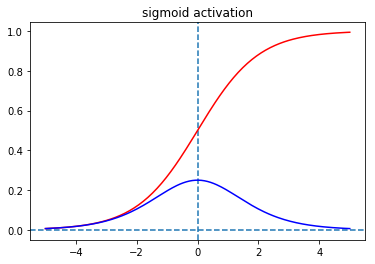

In [33]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("sigmoid activation")
plt.plot(x,Sigmoid().function(x), color="red")
plt.plot(x,Sigmoid().derivative(x), color="blue")

#### ReLU

In [34]:
Latex(r"""\begin{align}
f(x)=\begin{cases}
  x, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}\quad
f'(x)=\begin{cases}
  1, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}
\end{align}""")

<IPython.core.display.Latex object>

In [35]:
class Relu(Activation):
    
    def function(self, x):
        return x * (x > 0)

    def derivative(self, x):
        return np.array(self.function(x) != 0, dtype="int")

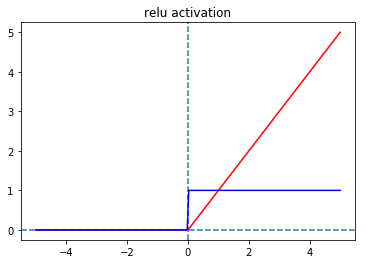

In [118]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("relu activation")
plt.plot(x,Relu().function(x), color="red")
plt.plot(x,Relu().derivative(x), color="blue")

#### Softplus

In [123]:
Latex(r"""\begin{align}
f(x)=log(1 + e^x)
\quad
f'(x)=\frac{e^x}{1 + e^x}
\end{align}""")

<IPython.core.display.Latex object>

In [130]:
class Softplus(Activation):
    
    def function(self, x):
        return np.log(1 + np.exp(x))

    def derivative(self, x):
        return np.exp(x)/(1 + np.exp(x))

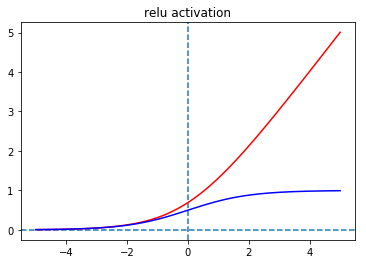

In [127]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("relu activation")
plt.plot(x,Softplus().function(x), color="red")
plt.plot(x,Softplus().derivative(x), color="blue")

#### Hyperbolic Tangent

In [128]:
Latex(r"""\begin{align}
f(x)=\frac{e^{2x}-1}{e^{2x}+1}
\quad
f'(x)=\frac{4}{{e^{2x}+2+e^{-2x}}}
\end{align}""")

<IPython.core.display.Latex object>

In [129]:
class Tanh(Activation):
    
    def function(self, x):
        return (np.exp(2*x) - 1)/(np.exp(2*x) + 1)

    def derivative(self, x):
        # hyperbolic secant to the power of 2
        return 4/(np.exp(2*x) + 2 + np.exp(-2*x))

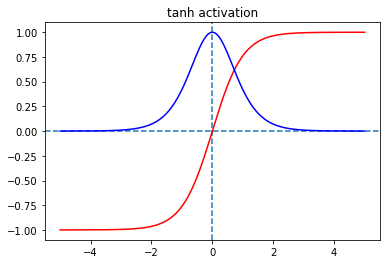

In [117]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("tanh activation")
plt.plot(x,Tanh().function(x), color="red")
plt.plot(x,Tanh().derivative(x), color="blue")

#### Linear

In [40]:
class Linear(Activation):
    
    def function(self, x):
        return x

    def derivative(self, x):
        return 1

## Input Pipeline

In my implementation of a feed-forward net I've detached the responsibility of feeding the data into the network from the calculation model. The task of this class is to manage the input by separating the data into train, test and validation subsets, and standardizing these with the deviation and mean values of the training data. During training or testing the network receives the input in batches, which are also assembled by this class.

In [41]:
class InputPipeLine:
    
    def __init__(self, data, train_split=0.6, valid_split=0.2, batch_size=10):
        """data: an array of the training, validation, and test samples, 
        where each elements consists of an array of inputs (features), 
        and an array of expected output(s) for the given input"""
        self.scaler = None
        self.data = None
        self.size = None
        self.actual_batch_size = None
               
        self.train_size = int(len(data)*train_split)
        self.valid_size = int(len(data)*valid_split)
        self.test_size = len(data)-self.valid_size-self.train_size
        
        assert self.test_size > 0
        
        self.batch_size = batch_size
        
        self.train, self.valid, self.test = self.separate(self.normalize(data))
        self.index = 0
        
    def normalize(self, data):        
        features = [row[0] for row in data]
        self.scaler = preprocessing.StandardScaler().fit(features[:self.train_size])
        data = list(zip(self.scaler.transform(features), [row[1] for row in data]))
        return data
    
    def separate(self, data):
        return (data[:self.train_size], data[self.train_size:self.train_size+self.valid_size],
                data[self.train_size+self.valid_size:])
            
    def next_batch(self):
        batch, eoe = self.step()
        # inputs are separated from their expected output
        # their order must remain the same
        return (np.array([element[0] for element in batch]),
                np.array([element[1] for element in batch]),
                eoe)
    
    def set_mode(self, mode="train"):
        """switching between phases, so the step function doesn't have to know, which is the current state"""
        # TODO: reconsider this method
        if mode == "train":
            self.data = self.train
            self.size = self.train_size
            self.actual_batch_size = self.batch_size
        elif mode == "validation":
            self.data = self.valid
            self.size = self.valid_size
            self.actual_batch_size = self.valid_size
        elif mode == "test":
            self.data = self.test
            self.size = self.test_size
            self.actual_batch_size = self.test_size
            
    
    def step(self):
        # flag value signaling the end of an epoch
        eoe = False
        if self.index + self.actual_batch_size > self.size:
            self.index = 0
            # samples are shuffled after each epoch
            shuffle(self.data)
            eoe = True
        
        batch = self.data[self.index:self.index+self.actual_batch_size]
        self.index += self.actual_batch_size
        
        return batch, eoe

## Layers

In [42]:
class Layer:
    
    def __init__(self, activation, size):
        self.activation = activation
        self.value = None
        self.size = size
        
    def forward(self, x):
        self.value = self.activation.function(x)
        return self.value
        
    def backward(self):
        return self.activation.derivative(self.value)
    
    def isDropout(self):
        return False

#### Dropout

A reguralization layer that creates a mask over the neurons, and nullifies each output value with p probability. Dropout prevents overfitting as it combines an exponential amount of network architectures, rendering the ability of the individual neurons to develop co-dependency amongst each other during the training phase significantly lower. The network is forced to learn the data with a different subset of parameters, which means it has to learn a more generalized representation of the data to generate good results.

Let i be the i-th layer in a feed-forward neural network, x denote the vector output of the (i-1)-th layer, W and b are the weights and biases between the (i-1)-th and i-th layer, and m be a mask that has the same dimensions as x. The multiplication in the (2) is an element-wise product, while the one in (3) is standard matrix multiplication dot product.

In [43]:
Latex(r"""\begin{align}
m^{(i-1)} \sim Bernoulli(p) \\
\tilde{x}^{(i-1)} = x^{(i-1)}\cdot m^{(i-1)} \\
s^{(i)}=W^{(i-1)}\cdot \tilde{x}^{(i-1)}+b^{(i-1)} \\
y^{(i)}=f(s^{(i)})
\end{align}""")

<IPython.core.display.Latex object>

By applying the dropout on a layer, we are using only n*p (n is the number of units in a layer) neurons, hence, the expected output is p times the output without dropout. During testing phase or inference, we want to use the full neural network, so we have to scale down the output values in that layer. An alternative way of handling this issue is scaling up the output of the neurons during training phase, by dividing with p, so we don't have to deal with scaling during testing phase.

In [44]:
class Dropout(Layer):
    
    def __init__(self, layer, probability):
        super().__init__(layer.activation, layer.size)
        self.probability = probability
        # bernoulli distribution as the probabilty of retaining the neuron
        self.mask = np.random.binomial(1, self.probability, size=self.size)
    
    def forward(self, x):
        # using the "alternative" method described above
        return np.multiply(Layer.forward(self, x), self.mask)/self.probability
        
    def backward(self):
        # recreate the mask after the backward step
        product = np.multiply(Layer.backward(self), self.mask)
        self.mask = np.random.binomial(1, self.probability, size=self.size)
        return product
    
    def isDropout(self):
        return True
    
    def remask(self, probability):
        self.mask = np.random.binomial(1, probability, size=self.size)

#### Batch normalization

In [45]:
class BatchNorm(Layer):
    pass

#### Softmax

In [140]:
class Softmax(Layer):
    
    def __init__(self, size):
        super().__init__(None, size)

    def forward(self, x):
        self.value = np.exp(x)/(np.sum(np.exp(x), axis=1))
        return self.value
        
    def backward(self):
        return self.activation.derivative(self.value)

## Optimizers

#### Stochastic Gradient Descent with Momentum

In [47]:
class Sgd:
    
    def __init__(self, lrate=0.01, momentum=0.9):
        self.lrate = lrate
        self.momentum = momentum
        self.dws = None
        self.dbs = None

    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.dws is None:
            self.dws = [0]*len(weights)
            self.dbs = [0]*len(weights)
            
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = (-self.lrate*np.dot(layers[index].value.T, delta) + 
                  self.momentum*self.dws[index])/batch_size
            self.dws[index] = dw
            
            db = np.sum(-self.lrate*delta + self.momentum*self.dbs[index], axis=0)/batch_size
            self.dbs[index] = db
            
            weights[index] += dw
            biases[index] += db

#### Adaptive Subgradient

In [48]:
class Adagrad:
    
    def __init__(self, lrate=0.01, epsilon=10e-4):
        self.lrate = lrate
        self.epsilon = epsilon
        self.walphas = None
        self.balphas = None
    
    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.walphas is None:
            self.walphas = [0]*len(weights)
            self.balphas = [0]*len(weights)
            
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = np.dot(layers[index].value.T, delta)/batch_size
            walpha = self.walphas[index] + dw**2
            self.walphas[index] = walpha
            
            db = np.sum(delta, axis=0)/batch_size
            balpha = self.balphas[index] + db**2
            self.balphas[index] = balpha
            
            weights[index] += (-self.lrate*dw/(walpha**(1/2)+self.epsilon))
            biases[index] += (-self.lrate*db/(balpha**(1/2)+self.epsilon))

#### RMSProp

In [49]:
class Rmsprop:
    
    def __init__(self, lrate=0.01, alpha=0.9, epsilon=10e-4):
        self.lrate = lrate
        self.alpha = alpha
        self.epsilon = epsilon
        self.walphas = None
        self.balphas = None
    
    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.walphas is None:
            self.walphas = [0]*len(weights)
            self.balphas = [0]*len(weights)
            
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = np.dot(layers[index].value.T, delta)/batch_size
            walpha = self.alpha*self.walphas[index] + (1-self.alpha)*dw**2
            self.walphas[index] = walpha
            
            db = np.sum(delta, axis=0)/batch_size
            balpha = self.alpha*self.balphas[index] + (1-self.alpha)*db**2
            self.balphas[index] = balpha
            
            weights[index] += (-self.lrate*dw/(walpha**(1/2)+self.epsilon))
            biases[index] += (-self.lrate*db/(balpha**(1/2)+self.epsilon))

#### ADAM

In [87]:
Latex(r"""\begin{align}
t\gets t+1 \\
g_t\gets \Delta_\theta f_t(\theta_{t-1}) \\
m_t\gets \beta_1\cdot m_{t-1}+(1-\beta_1)\cdot g_t \\
v_t\gets \beta_2\cdot v_{t-1}+(1-\beta_2)\cdot g_t^2 \\
\bar{m_t}\gets \frac{m_t}{1-\beta_1^t} \\
\bar{v_t}\gets \frac{v_t}{1-\beta_2^t} \\
\theta_t \gets \theta_{t-1}-\frac{\alpha\cdot \bar{m_t}}{\sqrt{\bar{v_t}}+\epsilon}
\end{align}""")

<IPython.core.display.Latex object>

In [50]:
class Adam():
    
    def __init__(self, lrate=0.01, beta1=0.9, beta2=0.999, epsilon=10e-8):
        self.lrate = lrate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mws = None
        self.mbs = None
        self.vws = None
        self.vbs = None
        self.t = 0
    
    def modify_weights(self, batch_size, layers, weights, biases, deltas):
        if self.mws is None:
            self.mws = [0]*len(weights)
            self.mbs = [0]*len(weights)
            self.vws = [0]*len(weights)
            self.vbs = [0]*len(weights)
            
        self.t += 1
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = np.dot(layers[index].value.T, delta)/batch_size
            mw = self.beta1*self.mws[index] + (1-self.beta1)*dw
            vw = self.beta2*self.vws[index] + (1-self.beta2)*dw**2
            mw_h = mw/(1-self.beta1**self.t)
            vw_h = vw/(1-self.beta2**self.t)
            self.mws[index] = mw
            self.vws[index] = vw
            
            db = np.sum(delta, axis=0)/batch_size
            mb = self.beta1*self.mbs[index] + (1-self.beta1)*db
            vb = self.beta2*self.vbs[index] + (1-self.beta2)*db**2
            mb_h = mb/(1-self.beta1**self.t)
            vb_h = vb/(1-self.beta2**self.t)
            self.mbs[index] = mb
            self.vbs[index] = vb
            
            weights[index] += (-self.lrate*mw_h/(vw_h**(1/2)+self.epsilon))
            biases[index] += (-self.lrate*mb_h/(vb_h**(1/2)+self.epsilon))

## Error

In [51]:
class Error(metaclass=abc.ABCMeta):
    # unnecessary
    
    @abc.abstractmethod
    def function(self, target, pred):
        """Implementation of the error function."""
        
    @abc.abstractmethod
    def derivative(self, target, pred):
        """Derivative of the error function."""

#### Mean square error

In [52]:
class Mse(Error):
    
    def function(self, target, pred):
        return (y-pred)**2
    
    def derivative(self, target, pred):
        return -2*(y-pred)

#### Cross Entropy

In [65]:
class CrossEntropy(Error):
    
    def function(self, target, pred):
        return target*np.log(pred)
    
    def derivative(self, target, pred):
        return 0

#### Binary Cross Entropy

In [ ]:
class BinaryCrossEntropy(Error):
    
    def function(self, target, pred):
        return -(target*np.log(pred) + (1 - target)*np.log(1 - pred))
    
    def derivative(self, target, pred):
        return 

## Model

In [95]:
class Mlp:
    
    def __init__(self, layers, input_pipe, error=Mse()):
        self.layers = layers
        self.input_pipe = input_pipe
        self.error = error
        self.weights, self.biases = self.init_weights()
        
        self.optimizer = None
        self.batch_size = None
        
    def init_weights(self):
        weights = []
        biases = []
        for index in range(len(self.layers)-1):
            # xavier weight initialization
            xav_scale = (6/(self.layers[index].size**(1/2)+self.layers[index+1].size**(1/2)))
                
            weights.append(np.random.rand(self.layers[index].size, 
                                          self.layers[index + 1].size)*2*xav_scale-xav_scale)
            biases.append(np.random.rand(1, 
                                         self.layers[index + 1].size)*2*xav_scale-xav_scale)

        return weights, biases
            
    def train(self, epochs=100, optimizer=Sgd()):
        self.optimizer = optimizer
        
        for epoch in range(epochs):
            self.input_pipe.set_mode("train")
            
            train_error = 0
            valid_error = 0
            
            while True:
                x, y, eoe = self.input_pipe.next_batch()
                if eoe:
                    break
                self.forward_prop(x)
                train_error += self.back_prop(y)
                
                    
            self.input_pipe.set_mode("validation")
            x, y, _ = self.input_pipe.next_batch()
            
            valid_error = (self.error.function(y, self.predict(x)).sum()
            /self.input_pipe.valid_size/self.layers[-1].size)
            train_error = (train_error/self.input_pipe.train_size/self.layers[-1].size)
            
            if epoch % 20 == 0:
                print(">>> Epoch: {0}\t Train Error: {1:.3f}\t Validation Error: {2:.3f}"
                      .format(epoch, train_error, valid_error))
            
    def predict(self, x):
        self.layers[0].forward(x)
        
        for index in range(len(self.weights)):
            layer = self.layers[index+1]
            
            # removing dropout mask
            if layer.isDropout():
                layer.remask(1)
                
            layer.forward(np.dot(self.layers[index].value, 
                                 self.weights[index]) + self.biases[index])
            
            # replacing the mask
            if layer.isDropout():
                layer.remask(layer.probability)
        
        return self.layers[-1].value
    
    def test(self, x=None, target=None, verbose=1):
        # to make a custom prediction both x (inputs) and y (expected outputs) must be given
        if x or target is None:
            # otherwise prediction will be made from the test set
            self.input_pipe.set_mode("test")
            x, target, _ = self.input_pipe.next_batch()
        
        results = list(zip(x, target, self.predict(x)))
        for index, row  in enumerate(results):
            if index > len(results)*verbose:
                break
            print(">>> Expected: {0}  Prediction: {1}\t".format(row[1], row[2]))
            
        return results
                
    def forward_prop(self, x):
        self.batch_size = x.shape[0]
        self.layers[0].forward(x) # tanuljá robi
        
        for index in range(len(self.weights)):
            self.layers[index+1].forward(np.dot(self.layers[index].value, 
                            self.weights[index]) + self.biases[index])
        
    def back_prop(self, target):
        deltas = []
        # y is the expected output
        err = self.error.derivative(target, self.layers[-1].value)
        deltas.append(np.multiply(err, self.layers[-1].backward()))
        
        for index in range(len(self.weights)-1, 0,-1):
            deltas.insert(0, np.multiply(np.dot(deltas[0],self.weights[index].T), 
                                      self.layers[index].backward()))
        
        self.optimizer.modify_weights(self.batch_size, self.layers, self.weights, self.biases, deltas)
        
        return self.error.function(target, self.layers[-1].value).sum()    

## Examples

#### XOR problem

>>> Epoch: 0	 Train Error: 0.216	 Validation Error: 0.112
>>> Epoch: 20	 Train Error: 0.025	 Validation Error: 0.036
>>> Epoch: 40	 Train Error: 0.023	 Validation Error: 0.036
>>> Epoch: 60	 Train Error: 0.025	 Validation Error: 0.036
>>> Epoch: 80	 Train Error: 0.024	 Validation Error: 0.038
>>> Expected: [1]  Prediction: [ 0.99451534]	
>>> Expected: [1]  Prediction: [ 0.99836664]	
>>> Expected: [1]  Prediction: [ 0.99999915]	
>>> Expected: [1]  Prediction: [ 1.]	
>>> Expected: [1]  Prediction: [ 0.97425323]	
>>> Expected: [0]  Prediction: [  9.43350637e-06]	
>>> Expected: [1]  Prediction: [ 0.98982347]	
>>> Expected: [0]  Prediction: [ 0.00044601]	
>>> Expected: [1]  Prediction: [ 0.99783435]	
>>> Expected: [1]  Prediction: [ 0.98304749]	
>>> Expected: [0]  Prediction: [ 0.00045705]	
>>> Expected: [0]  Prediction: [  5.99122953e-05]	
>>> Expected: [1]  Prediction: [ 0.97391754]	
>>> Expected: [1]  Prediction: [ 0.99999083]	
>>> Expected: [0]  Prediction: [ 0.0224111]	
>>> Expected: [

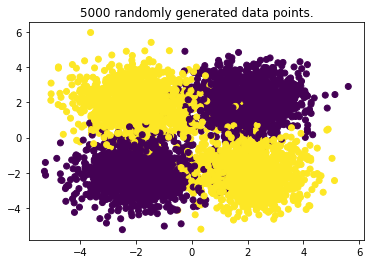

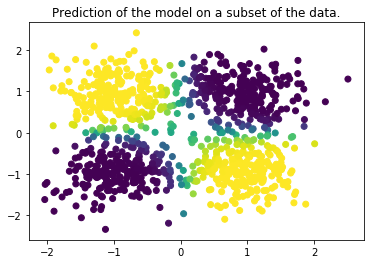

In [137]:
np.random.seed(1)

nb_samples = 5000
samples = []
distance = 2
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples.append([[-distance+noise[0],-distance+noise[1]], [0]])
    samples.append([[distance+noise[2],-distance+noise[3]],[1]])
    samples.append([[-distance+noise[4],distance+noise[5]],[1]])
    samples.append([[distance+noise[6],distance+noise[7]], [0]])

fig1=plt.figure()
plt.title("{0} randomly generated data points.".format(nb_samples))
plt.scatter([element[0][0] for element in samples],
            [element[0][1] for element in samples],
            c=[element[1] for element in samples])

input_pipe = InputPipeLine(samples, batch_size=20)

layers = []
layers.append(Layer(Linear(), size=2))
layers.append(Layer(Softplus(), size=10))
layers.append(Softmax(size=1))

mlp_object = Mlp(layers, input_pipe, error=Mse())
mlp_object.train(epochs=100, optimizer=Adam(lrate=0.01))
results = mlp_object.test(verbose=0.05)

fig2=plt.figure()
plt.title("Prediction of the model on a subset of the data.")
plt.scatter([element[0][0] for element in results],
            [element[0][1] for element in results],
            c=[element[2] for element in results])
     

#### MNIST classification